# Section 9: Unsupervised Learning with GANs!

Congrats making it to Week 9! It's been a tough quarter with all that's going on, but we're all really proud of all the progress and work you all have put into this course.

Time for something fun! 

## StyleGAN
Let's start with a super super cool application of GANs known as StyleGAN. Can you tell which people are real and which people are not? 

*Hint: you might not be able to tell from the faces alone* 👓, 💇🏽‍♀️, 👔

[Whice Face is Real?](http://www.whichfaceisreal.com/)


## **Goal**
Given samples $\{x\}_{i=1}^n$ drawn i.i.d. from an unknown probability distribution $Q(x)$, train a model that can generate samples from learned distribution, which resembles $Q(x)$. 

## Generative Adversarial Networks
Generative adversarial networks (GANs) are deep learning models, which, as part of the optimization process, learn a generating distribution $G(x)$ to resemble $Q(x)$.

## Libraries

In [0]:
from argparse import Namespace
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import transforms

%matplotlib inline


## Hyperparameters

It's good practice to specify project hyperparameters using argparse. Usually, we run experiments from the terminal and the typical code will look a bit more like the following:

```
import argparse
...
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument(...)
    ...
    hparams: argparse.Namespace = parser.parse_args()

if __name__ == '__main__':
    main()
```

In [0]:
args = {
    'batch_size': 128,
    'dis_lr': 0.0001, 
    'epochs': 150,
    'gen_lr': 0.0001,
    'latent_dim': 100,
    'log_interval': 150,
    'seed': 446
}
hparams = Namespace(**args)


## Devices, Datasets, and DataLoaders
Say that three times fast 😄

Running this notebook on a CPU will take too long. Verify that you are able to run on a CUDA device.

`Runtime -> Change runtime type -> Hardware Accelerator: GPU`

In [3]:
device = torch.device('cuda:0"' if torch.cuda.is_available() else 'cpu')
print('using device', device)

using device cuda:0


We'll be training our GAN on the `FashionMNIST` dataset. `FashionMNIST` is very similar to `MNIST`. Same number of samples and same dimensionality! That is, $X_{\text{Train}} \in \mathbb{R}^{60,000 \times 28 \times 28}$.

In [4]:
data_train = datasets.FashionMNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

data_test = datasets.FashionMNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())
num_workers = torch.multiprocessing.cpu_count()
train_dataloader = DataLoader(dataset=data_train, 
                          batch_size=hparams.batch_size,
                          num_workers=num_workers,
                          shuffle=True)
# no need for a test loader

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


<Figure size 432x288 with 0 Axes>

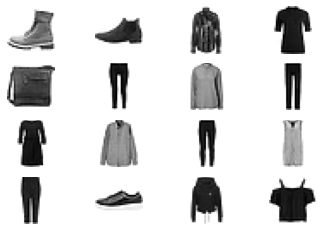

In [5]:
samples = [] # why is writing matplotlib code so gross? :((((
for _, (data, _) in enumerate(train_dataloader):
    for i in range(16):
        samples.append(data[i, :, :, :].squeeze(dim=0).numpy())
    break
plt.figure()
i, j = 0, 0 
_, subplots = plt.subplots(nrows=4, ncols=4)
for sample in samples:
    subplots[j][i].imshow(sample, cmap='binary') # also try binary 
    subplots[j][i].set_axis_off()
    i += 1
    if i % 4 == 0:
        j += 1 
        i = 0
plt.show()

## Defining the Model(s)
Let's play a (zero-sum) game 😈 mwahahaha

1. We have a generator network whose job is to create forgeries, which resemble the data.
2. We have a discriminator network whose job is to separate forgeries from originals. 

Let $G$ be the generator and let $D$ be the discriminator.


*   $G$ is trying to trick $D$.
*   $D$ is trying to not get punked by $G$.



### Generator
If the discriminator was fixed, then the objective is $ \min_G L(G, D)$, where the likelihood function is $$ L(G, D) = \frac{1}{2}\mathbb{E}_{x\sim Q}\left[ \text{log}(D(x)) \right] + \frac{1}{2}\mathbb{E}_{x\sim G} \left[\text{log}(1 - D(x)\right]$$

However, the discriminator is not fixed! Both the generator and discriminator get better over time. Generator is trying to make the discriminator's likelihood small.

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(hparams.latent_dim, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )
      
    def forward(self, z):
        img = self.generator(z)
        return img

# module utility to reshape latent features into a tensor that can be processed by atrous convolutions
class Reshape(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)

### Discriminator
The discriminator is a binary classifer: fake? or not fake? For a given distribution $G(x)$ and samples from the true underlying distribution $Q(x)$, we can learn $D$!

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            nn.Dropout2d(p=0.2),
            Flatten(),
            nn.Linear(7*7*32, 1),
        )
    
    def forward(self, img):
        pred = self.discriminator(img)
        return pred.view(-1)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


We can 

In [12]:
torch.manual_seed(hparams.seed)

forger = Generator()
forger.to(device)

detective = Discriminator()
detective.to(device)

print(forger)
print(detective)

Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.0001, inplace=True)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## "The Name of the Game": Optimization
Recall the likelihood objective. The game is viewed as:
$$ \min_G \max_D \frac{1}{2}\mathbb{E}_{x\sim Q}\left[ \text{log}(D(x)) \right] + \frac{1}{2}\mathbb{E}_{x\sim G} \left[\text{log}(1 - D(x)\right]$$

The optimization process for GANs is a bit more subtle than what we've done previously. As opposed to 'hill-climbing' we have two competing, learning networks, which play a sort of minimax game against each other until an equilibrium is (hopefully 🤞🏽) reached.

In [0]:
optimizer_G = torch.optim.Adam(forger.parameters(), lr=hparams.gen_lr)
optimizer_D = torch.optim.Adam(detective.parameters(), lr=hparams.dis_lr)

## Learning

In [14]:
tic = time.time()    
losses_D, losses_G = [], []
for epoch in range(hparams.epochs):
    detective.train()
    forger.train()
    print('Epoch: %03d/%03d' % (epoch+1, hparams.epochs))
    for batch_idx, (data, targets) in enumerate(train_dataloader):
        ### data preparation start ###
        data = (data - 0.5)*2.  # normalization
        data, targets = data.view(-1, 784).to(device), targets.to(device)
        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)        
        ### data preparation end ##

        ### update + train step start: generator ###
        optimizer_G.zero_grad()
        # generator creates forgeries
        z = torch.zeros((targets.size(0), hparams.latent_dim)).uniform_(-1.0, 1.0).to(device)
        forgery = forger(z)
        # generator drives down loss to manipulate discriminator
        prediction = detective(forgery.view(targets.size(0), 1, 28, 28))
        forger_loss = F.binary_cross_entropy_with_logits(prediction, valid)
        forger_loss.backward()
        optimizer_G.step()
        ### update + train step end: generator ###
        
        ### update + train step start: discriminator ###       
        optimizer_D.zero_grad()
        prediction_real = detective(data.view(targets.size(0), 1, 28, 28))
        real_loss = F.binary_cross_entropy_with_logits(prediction_real, valid)
        prediction_forgery = detective(forgery.view(targets.size(0), 1, 28, 28).detach())
        forgery_loss = F.binary_cross_entropy_with_logits(prediction_forgery, fake)
        detective_loss = 0.5 * (real_loss + forgery_loss)
        detective_loss.backward()
        optimizer_D.step()        
        ### update + train step end: discriminator ###

        ### logging start ###
        losses_D.append(detective_loss.item())
        losses_G.append(forger_loss.item())
        # TODO: change default tabstop to 8, show students how to use tensorboard?
        if not batch_idx % hparams.log_interval:
            print('    Batch %03d/%03d | Generator Loss: %.4f | Discriminator Loss: %.4f' 
                   % (batch_idx, len(train_dataloader), forger_loss, detective_loss))
        ### logging end ###
    tictoc = (time.time() - tic) / 60  # ban tiktok?
    print('    Training Time: %.2f min' % (tictoc))
tictoc = (time.time() - tic) / 60
print('Total Training Time: %.2f min' % (tictoc))

Epoch: 001/150
    Batch 000/469 | Generator Loss: 0.7646 | Discriminator Loss: 0.7542
    Batch 150/469 | Generator Loss: 1.3542 | Discriminator Loss: 0.3431
    Batch 300/469 | Generator Loss: 1.6998 | Discriminator Loss: 0.2900
    Batch 450/469 | Generator Loss: 2.1205 | Discriminator Loss: 0.1857
    Training Time: 0.13 min
Epoch: 002/150
    Batch 000/469 | Generator Loss: 1.1217 | Discriminator Loss: 0.4883
    Batch 150/469 | Generator Loss: 1.1503 | Discriminator Loss: 0.4609
    Batch 300/469 | Generator Loss: 1.2254 | Discriminator Loss: 0.4740
    Batch 450/469 | Generator Loss: 1.2029 | Discriminator Loss: 0.4858
    Training Time: 0.26 min
Epoch: 003/150
    Batch 000/469 | Generator Loss: 1.1789 | Discriminator Loss: 0.5232
    Batch 150/469 | Generator Loss: 1.2228 | Discriminator Loss: 0.5106
    Batch 300/469 | Generator Loss: 1.3898 | Discriminator Loss: 0.4439
    Batch 450/469 | Generator Loss: 1.1263 | Discriminator Loss: 0.4886
    Training Time: 0.39 min
Epoch: 

## Evaluation

Let's take a look at how our losses change over time! Do the losses converge?

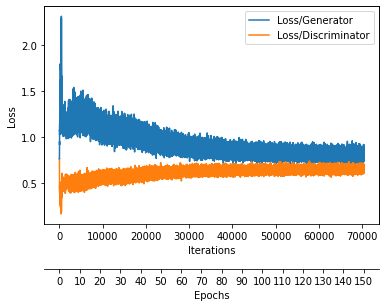

In [15]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(losses_G)), losses_G, label='Loss/Generator')
ax1.plot(range(len(losses_D)), losses_D, label='Loss/Discriminator')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = ax1.twiny()
newlabel = list(range(hparams.epochs+1))
iter_per_epoch = len(train_dataloader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
plt.show()

Once the training process is complete, the discriminator has served it's purpose. We simply throw it away, and now we can keep the generator to create 'fake' samples of the original data!

<Figure size 432x288 with 0 Axes>

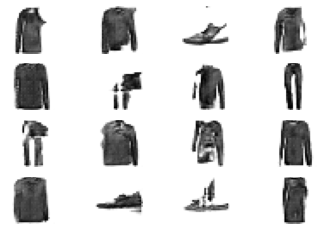

In [26]:
forger.eval()
z = torch.zeros((16, hparams.latent_dim)).uniform_(-1.0, 1.0).to(device)
generated_images = forger(z).view(-1, 28, 28)

samples = [] 
for i in range(16):
    # seriously, if anyone has suggestions on a new, cleaner visualization library, I'm all ears!
    samples.append(generated_images[i].to(cpu).detach().numpy())
    # I didn't bother making this code extensible, but basically replace any of the 4's you see with a 
    # number of choice in order to change the number of samples
plt.figure()
i, j = 0, 0 
_, subplots = plt.subplots(nrows=4, ncols=4)
for sample in samples:
    subplots[j][i].imshow(sample, cmap='binary') # also try binary 
    subplots[j][i].set_axis_off()
    i += 1
    if i % 4 == 0:
        j += 1 
        i = 0
plt.show()



## Challenges
* GANs are notoriously finnicky to train. They suffer from **mode collapse**, 
which is a phenomena where the generated
samples are not as diverse as the training samples.

* No, seriously! They can be a complete nightmare to train. Over the years the community has discovered some neat tricks to make training easier. 
  * Use a learning rate scheduler (see `torch.optim.lr_scheduler`)
  * Use soft-labels (add noise to the class labels)
  * Use a non-saturating loss function for the GAN. While this makes it NOT a zero-sum game, results tend to improve.
  * Better evaluation metrics?
  * See references for more...

* Attempts at using GANs for NLP have not been very successful. Instead, transformer architectures have set SOTA benchmarks across all NLP tasks in the last few years.

## Cool Applications
1. Imaginary fashion models and designs
2. Generating video game assets (from characters to trees)
3. Text to image synthesis (I give 'monkey', and GAN returns a picture 🤯)
4. Upscaling resolution of images
5. Dataset generation

Many more!

## Ethics
As discussed in lecture, GANs can be used to create 'deepfakes'. While plenty of the deepfake material out there is harmless, there exist more malicious applications of this technology 😕(fake news, revenge pornography). 

It's our responsibility to use deep learning wisely, and make sure the technology benefits people instead of hurting them!

        

